In [58]:
import os
import re
import json
import torch
from typing import Optional, List
import numpy as np
import pytorch_lightning as pl
import cv2
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
from albumentations import Compose, Resize, Normalize

PATH_DATA = "/home/ubuntu/datasets/segment_car_plate/data/"


In [59]:
with open(os.path.join(PATH_DATA, "train_recognition.json")) as fp:
    obj = json.load(fp)
fname2text = {os.path.basename(rec["file"]):rec["text"] for rec in obj}

assert len(obj) == len(fname2text)

config = []

for idx, fname in enumerate(
    os.listdir(os.path.join(PATH_DATA,"train"))
):
    if re.fullmatch(
        pattern=r"\d+\.box\.\d+\.jpg",
        string=fname
    ):
        config.append(
            (fname, fname2text[fname])
        )


In [61]:
class RecDataset(Dataset):
    def __init__(self, data_path, config, abc, split=None, transforms=None):
        super(RecDataset, self).__init__()
        self.data_path = data_path
        self.abc = abc
        self.transforms = transforms
        # self.split = split
        self.config = config

    def __len__(self):
        return len(self.config)

    def text_to_seq(self, text):
        seq = [self.abc.find(c) + 1 for c in text]
        return seq
    
    def __getitem__(self, idx):
        fname, text = self.config[idx]
        fpath = os.path.join(self.data_path, fname)
        try:
            image = cv2.imread(fpath).astype(np.float32) / 255.
        except Exception as exc:
            raise Exception(f"fpath={fpath}") from exc
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        seq = self.text_to_seq(text)
        seq_len = len(seq)
        if self.transforms is not None:
            image_rec = self.transforms(image=image)
            image = image_rec["image"]
        item = dict(image=image, seq=seq, seq_len=seq_len, text=text)
        return item

    @staticmethod
    def collate_fn(batch):
        images = list()
        seqs = list()
        seq_lens = list()
        for sample in batch:
            images.append(torch.from_numpy(sample["image"].transpose((2, 0, 1))).float())
            seqs.extend(sample["seq"])
            seq_lens.append(sample["seq_len"])
        images = torch.stack(images)
        seqs = torch.Tensor(seqs).int()
        seq_lens = torch.Tensor(seq_lens).int()
        batch = {"images": images, "seqs": seqs, "seq_lens": seq_lens, "texts":}
        return batch


C194AC174


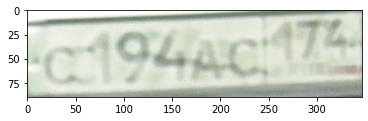

In [62]:
abc = "0123456789ABCEHKMOPTXY"
mapping = {
    'А': 'A',
    'В': 'B',
    'С': 'C',
    'Е': 'E',
    'Н': 'H',
    'К': 'K',
    'М': 'M',
    'О': 'O',
    'Р': 'P',
    'Т': 'T',
    'Х': 'X',
    'У': 'Y',
}
ds = RecDataset(
    data_path=os.path.join(PATH_DATA,"train"), config=config, abc=abc, split="train"
)
item = ds[-1]
print(item["text"])
plt.imshow(item["image"])


In [63]:
class RecDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data_path: str,
        config: List,
        split_proportions = (0.6, 0.8),
        batch_size = 32,
        image_size=256,
        seed = None,
    ):
        self.data_path = data_path
        self.split_proportions = split_proportions
        self.config = config
        self.n_img = len(self.config)
        self.batch_size = batch_size
        self.image_size = image_size
        self.transforms = self.get_transforms(image_size=self.image_size)
        self.abc = "0123456789ABCEHKMOPTXY"
        
    @staticmethod
    def get_transforms(image_size: int = 256):
        return Compose([
            Normalize(mean=(0.5, 0.5, 0.5), std=(0.25, 0.25, 0.25), max_pixel_value=1.),
            Resize(height=image_size, width=image_size, ),
            # ToTensorV2(),
        ])

    def setup(self, stage: Optional[str] = None):
        if stage == "3" or stage is None:
            # print(self.images[:5])
            # print(tuple(int(self.n_img*x) for x in self.split_proportions))
            self.train, self.val, self.test = np.split(
                self.config, 
                tuple(int(self.n_img*x) for x in self.split_proportions)
            )
        elif stage == "2":
            self.train, self.val = np.split(
                self.config, tuple(int(n_img*self.split_proportions[0]),)
            )
        elif stage == "1":
            self.train = self.images        
    
    def train_dataloader(self):
        # train_transforms = get_train_transforms(256)
        ds = RecDataset(
            data_path=self.data_path, config=self.train, transforms=self.transforms, abc=self.abc
        )
        return DataLoader(
            ds, 
            batch_size=self.batch_size, 
            shuffle=True, 
            # num_workers=2,
            collate_fn=ds.collate_fn
        )

    def val_dataloader(self):
        ds = RecDataset(data_path=self.data_path, config=self.val, abc=self.abc)
        return DataLoader(
            ds, 
            batch_size=self.batch_size,
            shuffle=True, 
            # num_workers=2,
            collate_fn=ds.collate_fn
        )

    def test_dataloader(self):
        ds = RecDataset(data_path=self.data_path, config=self.test, abc=self.abc)
        return DataLoader(
            ds, 
            batch_size=self.batch_size,
            shuffle=True, 
            # num_workers=2,
            collate_fn=ds.collate_fn
        )


In [65]:
item

{'images': tensor([[[[-1.2959, -1.1223, -0.8567,  ..., -0.1276, -0.1176, -0.1313],
           [-1.2994, -1.1192, -0.8354,  ..., -0.1399, -0.1300, -0.1508],
           [-1.3064, -1.1131, -0.7942,  ..., -0.1638, -0.1539, -0.1886],
           ...,
           [-1.5013, -1.4619, -1.4425,  ..., -1.3986, -1.4609, -1.5052],
           [-1.5172, -1.4779, -1.4585,  ..., -1.3927, -1.4401, -1.4952],
           [-1.5254, -1.4861, -1.4667,  ..., -1.3897, -1.4293, -1.4901]],
 
          [[-1.4370, -1.2635, -0.9979,  ..., -0.2217, -0.2118, -0.1981],
           [-1.4406, -1.2604, -0.9766,  ..., -0.2340, -0.2241, -0.2176],
           [-1.4476, -1.2543, -0.9354,  ..., -0.2579, -0.2480, -0.2554],
           ...,
           [-1.5640, -1.5247, -1.5053,  ..., -1.4927, -1.5551, -1.5856],
           [-1.5800, -1.5406, -1.5212,  ..., -1.4869, -1.5342, -1.5756],
           [-1.5882, -1.5488, -1.5294,  ..., -1.4839, -1.5234, -1.5705]],
 
          [[-1.4214, -1.2478, -0.9822,  ..., -0.1590, -0.1490, -0.1764],
   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


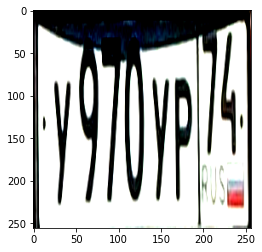

In [66]:
data = RecDataModule(data_path=os.path.join(PATH_DATA,"train"), config=config)
data.setup()
dataloader = data.train_dataloader()
for item in dataloader:
    break
plt.imshow(
    np.transpose(item["images"][0], (1, 2, 0))
)

In [68]:
item["seqs"]

tensor([22, 10,  8,  1, 22, 19,  8,  5, 21,  8,  6, 10, 14, 17,  8,  7, 18,  8,
         4,  9, 20, 11,  6,  8, 20,  2,  6,  4, 11, 13,  8,  1, 17,  1,  1,  7,
        11, 19,  2,  7,  4, 16,  6,  8,  8, 16, 20,  2, 10,  8, 11,  1, 10,  1,
        12, 20,  2, 10, 10,  0,  1, 10,  3,  0,  0,  3,  3, 15,  4, 10,  9, 21,
        17,  6,  4, 19,  5,  7,  1, 11, 11,  6,  6, 14,  1,  9,  8, 11, 13,  2,
         3, 17,  4,  5,  1, 16, 19,  2, 10,  1, 19,  9,  2,  4, 21, 17,  2, 10,
        10, 17,  1,  1,  3, 17, 17,  3,  5, 19,  3,  7,  1, 22, 17,  8,  7, 14,
        10, 10, 10, 21, 18,  6,  9, 11,  2,  1,  8, 18, 13,  7,  3, 13,  3,  1,
         1, 12, 13,  2, 10,  8,  0,  4,  7,  3,  0,  0, 10,  4, 16,  8,  6,  8,
        20, 13, 10,  4, 11,  9,  8,  6, 17, 20,  2, 10,  1, 11,  3,  2,  5, 13,
        21,  3,  8, 19,  5, 10,  6, 19, 19, 10, 10, 20,  8, 10, 10, 21, 22,  6,
         3, 13,  5,  1,  1, 17, 15,  2,  6,  1, 16,  6,  1,  5, 16, 16,  3,  8,
        20,  3,  9,  4, 16, 16,  3,  6, 